# Convolutional Neural Networks

In this task you are suppose to implement a convolutional neural network using a high level library, e.g. PyTorch.
The classification should be about food.
* Download the food 11 dataset https://mmspg.epfl.ch/food-image-datasets or https://www.kaggle.com/vermaavi/food11/data
* Predict the 11 classes: Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit
* Try some standard networks convolutional networks before more complex ones.
* Hint: Start with a subset of the dataset
* Choose the network architecture with care.
* Train and validate all algorithms.
* Make the necessary assumptions.

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from PIL import Image
import os
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


# Step 1: Load and preprocess the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


class FoodDataset(Dataset):
   def __init__(self, root_dir, transform=None):
       self.root_dir = root_dir
       self.transform = transform
       self.file_list = os.listdir(root_dir)

   def __len__(self):
       return len(self.file_list)

   def __getitem__(self, idx):
       img_name = os.path.join(self.root_dir, self.file_list[idx])
       image = Image.open(img_name)
       if self.transform:
           image = self.transform(image)
       label = int(self.file_list[idx].split("_")[0])
       return image, label


train_dir = 'food-11/training'
val_dir = 'food-11/validation'
eval_dir = 'food-11/evaluation'

train_dataset = FoodDataset(train_dir, transform=transform)
val_dataset = FoodDataset(val_dir, transform=transform)
eval_dataset = FoodDataset(eval_dir, transform=transform)


# Calculate the number of samples to use for training (10%)
n_train = len(train_dataset)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(0.1 * n_train))

# Get the random indices for the subset
train_idx = indices[:split]

# Create a sampler
train_sampler = SubsetRandomSampler(train_idx)


#train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
eval_loader = DataLoader(eval_dataset, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loss_acc_dict = {}

In [58]:
import torch
from sklearn.metrics import classification_report

def train_model(model, criterion, optimizer, num_epochs=10):
    model.to(device)
    
    # Initialize lists to keep track of loss and accuracy
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Calculate and store the average loss for this epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate and store the accuracy for this epoch
        epoch_accuracy = 100 * correct / total
        val_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss} Validation Accuracy: {epoch_accuracy}%')

    # Return the lists of losses and accuracies
    return train_losses, val_accuracies

def eval_model(model):
    model.eval()

    true_labels = []
    predictions = []
    
    with torch.no_grad():
        for images, labels in eval_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().tolist())
    
    #The 11 categories are Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit.
    target_names = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
    # Calculate Recall, Precision, and F1-score
    print(classification_report(true_labels, predictions, target_names=target_names))

In [59]:
# CNN with 2 convolutional layers and residual blocks
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Adding the identity (skip connection)
        out = self.relu(out)
        return out


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.res1 = ResidualBlock(32, 32)  # Residual Block
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.res2 = ResidualBlock(64, 64)  # Residual Block
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 11)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.res1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.res2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x


# Step 3: Train the CNN
simple_cnn_with_res_con = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn_with_res_con.parameters(), lr=0.001)

loss_acc_dict['custom'] = train_model(simple_cnn_with_res_con, criterion, optimizer)
eval_model(simple_cnn_with_res_con)

Epoch 1/10, Loss: 2.1154705764406323 Validation Accuracy: 33.38192419825073%
Epoch 2/10, Loss: 1.742380463575468 Validation Accuracy: 39.883381924198254%
Epoch 3/10, Loss: 1.4223523095587696 Validation Accuracy: 45.56851311953353%
Epoch 4/10, Loss: 1.0551777422235236 Validation Accuracy: 44.08163265306123%
Epoch 5/10, Loss: 0.6153775311307228 Validation Accuracy: 41.42857142857143%
Epoch 6/10, Loss: 0.2691917290434868 Validation Accuracy: 40.37900874635569%
Epoch 7/10, Loss: 0.13902563343132004 Validation Accuracy: 39.533527696793%
Epoch 8/10, Loss: 0.07030031960050676 Validation Accuracy: 40.583090379008745%
Epoch 9/10, Loss: 0.07899182341641725 Validation Accuracy: 38.80466472303207%
Epoch 10/10, Loss: 0.05995721811192068 Validation Accuracy: 40.96209912536443%
                 precision    recall  f1-score   support

          Bread       0.34      0.30      0.32       368
  Dairy product       0.31      0.15      0.20       148
        Dessert       0.36      0.34      0.35       5

## LeNet

In [60]:
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Assuming the input image has 3 channels (RGB)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # The image size reduces from 128 to 29 after convolutions and pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # `num_classes` should be set to the number of your food categories

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming `num_classes` is defined based on your dataset
num_classes = 11  # Example for 11 types of food
leNet = LeNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet.parameters(), lr=0.001)

# Move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
leNet.to(device)

loss_acc_dict['LeNet'] = train_model(leNet, criterion, optimizer)
eval_model(leNet)

Epoch 1/10, Loss: 2.1008527058999515 Validation Accuracy: 31.632653061224488%
Epoch 2/10, Loss: 1.8309742574938679 Validation Accuracy: 36.822157434402335%
Epoch 3/10, Loss: 1.6224351357487798 Validation Accuracy: 37.55102040816327%
Epoch 4/10, Loss: 1.396440029144287 Validation Accuracy: 40.64139941690962%
Epoch 5/10, Loss: 1.1280792336247885 Validation Accuracy: 38.89212827988338%
Epoch 6/10, Loss: 0.8404638095966821 Validation Accuracy: 39.35860058309038%
Epoch 7/10, Loss: 0.5823251187897809 Validation Accuracy: 36.588921282798836%
Epoch 8/10, Loss: 0.3799534332501464 Validation Accuracy: 36.20991253644315%
Epoch 9/10, Loss: 0.24490302550368326 Validation Accuracy: 35.626822157434404%
Epoch 10/10, Loss: 0.16702087484541256 Validation Accuracy: 36.0932944606414%
                 precision    recall  f1-score   support

          Bread       0.30      0.30      0.30       368
  Dairy product       0.23      0.30      0.26       148
        Dessert       0.34      0.34      0.34       

In [61]:
from torchvision.models import ResNet50_Weights
import torchvision.models as models
# Load the pretrained ResNet50 model
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Get the input dimension of the last layer
num_ftrs = resnet50.fc.in_features

# Replace the last fully connected layer (fc) with a new one that matches the number of classes
resnet50.fc = nn.Linear(num_ftrs, 11)

# Move the model to the appropriate device
resnet50 = resnet50.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

loss_acc_dict['ResNet50'] = train_model(resnet50, criterion, optimizer)
eval_model(resnet50)

Epoch 1/10, Loss: 0.969671885461869 Validation Accuracy: 77.23032069970846%
Epoch 2/10, Loss: 0.5637535667438723 Validation Accuracy: 76.7930029154519%
Epoch 3/10, Loss: 0.39201555097276725 Validation Accuracy: 70.26239067055394%
Epoch 4/10, Loss: 0.27036130791198476 Validation Accuracy: 69.35860058309038%
Epoch 5/10, Loss: 0.22231342877384913 Validation Accuracy: 76.53061224489795%
Epoch 6/10, Loss: 0.17632143697656186 Validation Accuracy: 80.17492711370262%
Epoch 7/10, Loss: 0.15684703769144212 Validation Accuracy: 80.466472303207%
Epoch 8/10, Loss: 0.1241571294689328 Validation Accuracy: 76.82215743440233%
Epoch 9/10, Loss: 0.1112747628627568 Validation Accuracy: 78.68804664723032%
Epoch 10/10, Loss: 0.10837629162420105 Validation Accuracy: 76.76384839650146%
                 precision    recall  f1-score   support

          Bread       0.78      0.61      0.69       368
  Dairy product       0.67      0.73      0.70       148
        Dessert       0.73      0.72      0.72       50

In [62]:
from torchvision.models import ResNet152_Weights

# Load the pretrained ResNet50 model
resnet152 = models.resnet152(weights=ResNet152_Weights.DEFAULT)

# Get the input dimension of the last layer
num_ftrs = resnet152.fc.in_features

# Replace the last fully connected layer (fc) with a new one that matches the number of classes
resnet152.fc = nn.Linear(num_ftrs, 11)

# Move the model to the appropriate device
resnet152 = resnet152.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=0.001)

loss_acc_dict['ResNet152'] = train_model(resnet152, criterion, optimizer)
eval_model(resnet152)

Epoch 1/10, Loss: 0.9543005799977139 Validation Accuracy: 71.31195335276968%
Epoch 2/10, Loss: 0.5448623944351203 Validation Accuracy: 75.36443148688046%
Epoch 3/10, Loss: 0.3441826277759083 Validation Accuracy: 77.14285714285714%
Epoch 4/10, Loss: 0.26178381120647426 Validation Accuracy: 77.40524781341108%
Epoch 5/10, Loss: 0.19935763217388233 Validation Accuracy: 74.25655976676384%
Epoch 6/10, Loss: 0.16426622628574908 Validation Accuracy: 78.89212827988338%
Epoch 7/10, Loss: 0.1443389867308842 Validation Accuracy: 79.30029154518951%
Epoch 8/10, Loss: 0.12383100249831683 Validation Accuracy: 77.75510204081633%
Epoch 9/10, Loss: 0.12163431274864377 Validation Accuracy: 78.74635568513119%
Epoch 10/10, Loss: 0.0995353245260013 Validation Accuracy: 79.067055393586%
                 precision    recall  f1-score   support

          Bread       0.80      0.72      0.76       368
  Dairy product       0.68      0.68      0.68       148
        Dessert       0.77      0.76      0.76       5

In [63]:
from torchvision.models import GoogLeNet_Weights

# Load the pretrained ResNet50 model
googlenet = models.googlenet(weights=GoogLeNet_Weights.DEFAULT)

# Get the input dimension of the last layer
num_ftrs = googlenet.fc.in_features

# Replace the last fully connected layer (fc) with a new one that matches the number of classes
googlenet.fc = nn.Linear(num_ftrs, 11)

# Move the model to the appropriate device
resnet152 = googlenet.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.parameters(), lr=0.001)

loss_acc_dict['GoogLeNet'] = train_model(googlenet, criterion, optimizer)
eval_model(googlenet)

Epoch 1/10, Loss: 1.1349094809066131 Validation Accuracy: 68.19241982507289%
Epoch 2/10, Loss: 0.7442159078846472 Validation Accuracy: 68.33819241982508%
Epoch 3/10, Loss: 0.5677531019190755 Validation Accuracy: 73.73177842565597%
Epoch 4/10, Loss: 0.44873704023442224 Validation Accuracy: 67.14285714285714%
Epoch 5/10, Loss: 0.3773384213833361 Validation Accuracy: 71.13702623906705%
Epoch 6/10, Loss: 0.30180140582296067 Validation Accuracy: 72.8862973760933%
Epoch 7/10, Loss: 0.2502080259247891 Validation Accuracy: 72.56559766763849%
Epoch 8/10, Loss: 0.2070273793148763 Validation Accuracy: 65.51020408163265%
Epoch 9/10, Loss: 0.23082061120969 Validation Accuracy: 73.06122448979592%
Epoch 10/10, Loss: 0.18942858384542385 Validation Accuracy: 73.23615160349854%
                 precision    recall  f1-score   support

          Bread       0.69      0.73      0.71       368
  Dairy product       0.59      0.61      0.60       148
        Dessert       0.81      0.52      0.63       500


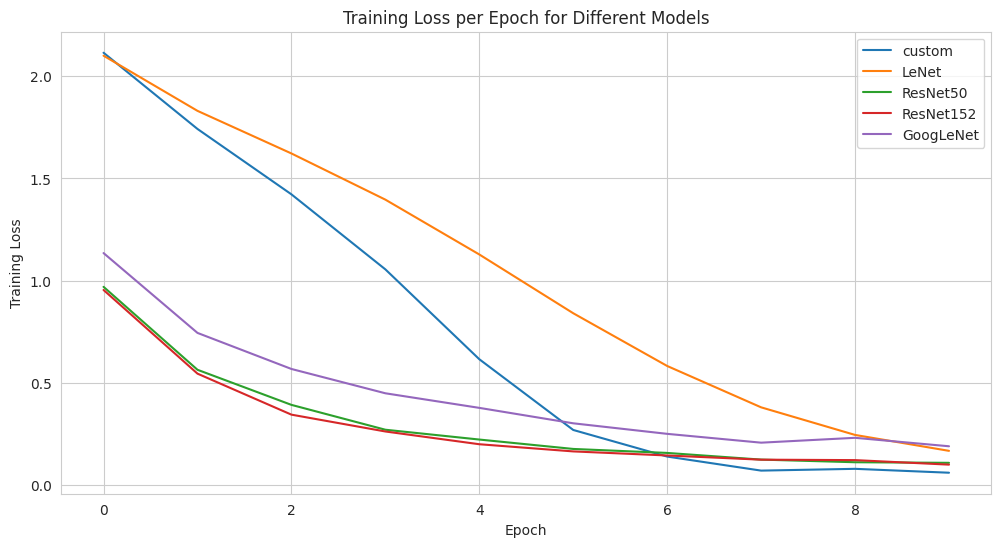

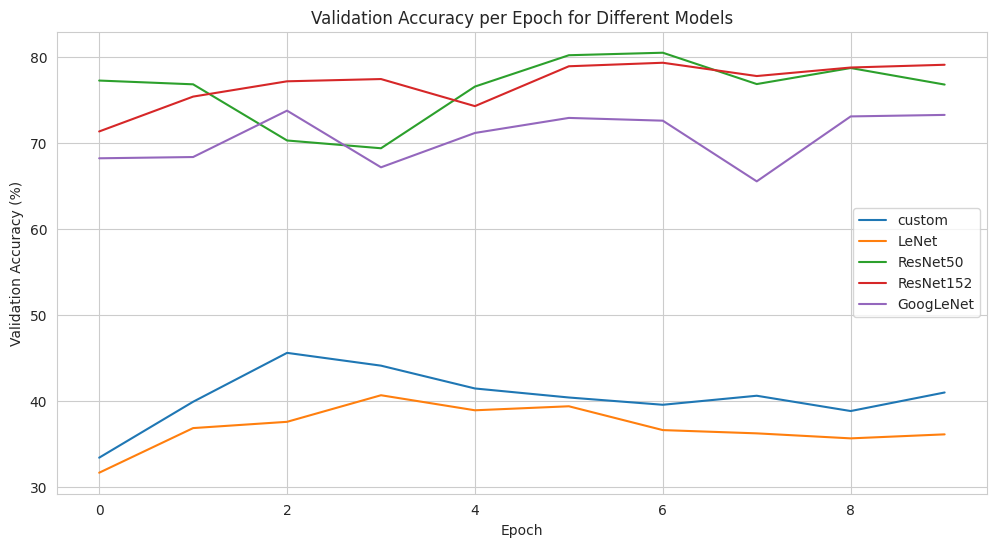

In [64]:
# Now you can plot the losses and accuracies using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set_style('whitegrid')

# Plot for training losses
plt.figure(figsize=(12, 6))
for name in loss_acc_dict.keys():
    sns.lineplot(x=range(0, len(loss_acc_dict[name][0])), y=loss_acc_dict[name][0], label=name)
plt.title('Training Loss per Epoch for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Plot for validation accuracies
plt.figure(figsize=(12, 6))
for name in loss_acc_dict.keys():
    sns.lineplot(x=range(0, len(loss_acc_dict[name][1])), y=loss_acc_dict[name][1], label=name)
plt.title('Validation Accuracy per Epoch for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.show()